# ATTN: This script uses Google translate to detect job description language. Google translate will limit requests and take a very long time. Only run this script if redoing language detection.

# Read from scrapped data

In [1]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2

In [2]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [3]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

#### Read paths

In [4]:
glob_paths = list(set(glob.glob(f'{scraped_data}Coding Material/*Folder/*/Job ID -*- Codebook (Automating Equity).xlsx')))


In [5]:
# 244 xlsx files
len(glob_paths)


244

#### Use paths to open files, fix keywords, and drop unneeded columns

In [6]:
# Fix list catches all incorrect/faculty keyword search terms

fix_list = []

# Appended data catches all the fixed and cleaned dfs
appended_data = []

for glob_path in glob_paths:

    try:
        df_temp = pd.read_excel(glob_path).reset_index(drop=True)
    except ValueError:
        fix_list.append(glob_path)

    if len(df_temp) > 0 and isinstance(df_temp, pd.DataFrame):
        df_temp.reset_index(drop=True, inplace=True)
        df_temp.drop(columns=cols, axis='columns', inplace=True, errors='ignore')
        df_temp.drop(
        df_temp.columns[
                df_temp.columns.str.contains(
                    'unnamed|index|level', regex=True, case=False, flags=re.I
                )
            ],
            axis='columns',
            inplace=True,
            errors='ignore',
        )

        appended_data.append(df_temp.reset_index(drop=True))

# Concatonate list of dfs into one large df_manual
df_manual = pd.concat(appended_data).reset_index(drop=True)

# Save df_manual to file
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [7]:
# If we couldn't fix some keywords, we add them to list fix_list and write to file
if len(fix_list) != 0:
    print('Some keywords to fix!')
    with open(f'{data_dir}fix_list.txt', 'w') as f:
        json.dump(fix_list, f)


In [8]:
# List of dfs, len = 244
len(appended_data)


244

In [9]:
# Concatonate list of dfs into one large df_manual
df_manual = pd.concat(appended_data).reset_index(drop=True)


In [10]:
# len = 12400
len(df_manual)


12400

In [11]:
# Save df_manual to file
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Drop duplicated and missing data

### START HERE IF SOURCING FROM df_manual_RAW
### PLEASE SET CORRECT DIRECTORY PATHS BELOW

In [12]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2

In [13]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [14]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [15]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw.pkl').reset_index(drop=True)


In [16]:
# len = 12400
len(df_manual)


12400

In [17]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job ID           12400 non-null  object 
 1   Sentence         12396 non-null  object 
 2   Warmth           12398 non-null  float64
 3   Competence       12400 non-null  int64  
 4   Task_Mentioned   12398 non-null  float64
 5   Task_Warmth      12398 non-null  float64
 6   Task_Competence  12398 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 678.2+ KB


In [18]:
df_manual.columns

Index(['Job ID', 'Sentence', 'Warmth', 'Competence', 'Task_Mentioned',
       'Task_Warmth', 'Task_Competence'],
      dtype='object')

In [19]:
# Clean columns
df_manual.columns = df_manual.columns.to_series().apply(lambda x: str(x).strip())


In [20]:
# Remove columns 'Task_Mentioned', 'Task_Warmth', 'Task_Competence'
df_manual.drop(
    columns=['Task_Mentioned', 'Task_Warmth', 'Task_Competence'],
    axis='columns',
    inplace=True,
    errors='ignore'
)

In [21]:
df_manual['Warmth'] = df_manual['Warmth'].astype(np.float64)
df_manual['Competence'] = df_manual['Competence'].astype(np.float64)


In [22]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12400 entries, 0 to 12399
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Job ID      12400 non-null  object 
 1   Sentence    12396 non-null  object 
 2   Warmth      12398 non-null  float64
 3   Competence  12400 non-null  float64
dtypes: float64(2), object(2)
memory usage: 387.6+ KB


In [23]:
# Rename Sentence to 'Job Description spacy_sentencized'
df_manual.rename(
    columns = {
        'Sentence': 'Job Description spacy_sentencized'
    },
    inplace=True,
    errors='ignore'
)

In [24]:
df_manual.columns


Index(['Job ID', 'Job Description spacy_sentencized', 'Warmth', 'Competence'], dtype='object')

In [25]:
# Drop NA
df_manual.dropna(axis='index', how='all', inplace=True)
df_manual.dropna(axis='columns', how='all', inplace=True)
df_manual.dropna(
    subset = ['Job Description spacy_sentencized', 'Warmth', 'Competence'],
    inplace=True
)


In [26]:
# len = 12394
len(df_manual)


12394

In [27]:
# len = 133
df_manual.groupby(['Job ID'])['Job ID'].unique()


Job ID
2466455525                      [2466455525]
3768944208                      [3768944208]
4023920432                      [4023920432]
4039450758                      [4039450758]
4040119601                      [4040119601]
                               ...          
pj_68fdfd2b272e0e56    [pj_68fdfd2b272e0e56]
pj_8a0cc9d327b77ff2    [pj_8a0cc9d327b77ff2]
pj_a4ac3e531abef752    [pj_a4ac3e531abef752]
pj_b62dd960c26ce093    [pj_b62dd960c26ce093]
pj_e2cc3db57891f5d9    [pj_e2cc3db57891f5d9]
Name: Job ID, Length: 133, dtype: object

In [28]:
# Drop duplicates on subset of 'Job ID' and 'Sentence'
df_manual.drop_duplicates(subset=['Job ID', 'Job Description spacy_sentencized'], keep='first', ignore_index=True, inplace=True)


In [29]:
# len = 6400
len(df_manual)


6400

In [30]:
# Remove any rows with missing 'Job ID'
df_manual.drop(
    df_manual[
        (df_manual['Job ID'].isin(nan_list)) | 
        (df_manual['Job ID'].isnull()) | 
        (df_manual['Job ID'].isna())
    ].index, 
    axis='index',
    inplace=True,
    errors='ignore'
)


In [31]:
# len = 6400
len(df_manual)


6400

In [32]:
# Save df_manual to file
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw_dropped.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw_dropped.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Add English and Dutch language requirement columns

### START HERE IF SOURCING FROM df_manual_RAW_DROPPED
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [33]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2

In [34]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [35]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [36]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw_dropped.pkl').reset_index(drop=True)


In [37]:
# 6400
len(df_manual)


6400

In [38]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Job ID                             6400 non-null   object 
 1   Job Description spacy_sentencized  6400 non-null   object 
 2   Warmth                             6400 non-null   float64
 3   Competence                         6400 non-null   float64
dtypes: float64(2), object(2)
memory usage: 200.1+ KB


In [39]:
# Add language requirement column
# Use regex to find language requirement
dutch_requirement_pattern = r'[Ll]anguage: [Dd]utch|[Dd]utch [Pp]referred|[Dd]utch [Re]quired|[Dd]utch [Ll]anguage|[Pp]roficient in [Dd]utch|[Ss]peak [Dd]utch|[Kk]now [Dd]utch'
english_requirement_pattern = r'[Ll]anguage: [Ee]nglish|[Ee]nglish [Pp]referred|[Ee]nglish [Re]quired|[Ee]nglish [Ll]anguage|[Pp]roficient in [Ee]nglish|[Ss]peak [Ee]nglish|[Kk]now [Ee]nglish'


In [40]:
# Language requirements
# Dutch
if 'Dutch Requirement' in df_manual.columns:
    df_manual.drop(columns=['Dutch Requirement'], inplace=True)
df_manual['Dutch Requirement'] = np.where(
    df_manual['Job Description spacy_sentencized'].str.contains(dutch_requirement_pattern),
    'Yes',
    'No',
)

# English
if 'English Requirement' in df_manual.columns:
    df_manual.drop(columns=['English Requirement'], inplace=True)
df_manual['English Requirement'] = np.where(
    df_manual['Job Description spacy_sentencized'].str.contains(english_requirement_pattern),
    'Yes',
    'No',
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw_english_requirement.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [41]:
# Yes = 235
df_manual['Dutch Requirement'].value_counts()


No     6393
Yes       7
Name: Dutch Requirement, dtype: int64

In [42]:
# Yes = 526
df_manual['English Requirement'].value_counts()

No     6392
Yes       8
Name: English Requirement, dtype: int64

In [43]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl')
    
    df_manual.to_csv(f'{df_save_dir}df_manual_raw_language_requirement.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Add data from Sectors dataframe (see CBS directory under scrapped_data directory)


### START HERE IF SOURCING FROM df_manual_RAW_LANGUAGE_REQUIREMENT
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [44]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [45]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [46]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [47]:
# Funtion to print df gender and age info
def df_gender_age_info(
    df,
    ivs_all = [
        'Gender',
        'Gender_Num',
        'Gender_Female',
        'Gender_Mixed',
        'Gender_Male',
        'Age',
        'Age_Num',
        'Age_Older',
        'Age_Mixed',
        'Age_Younger',
    ],
):
    # Print Info
    print('\nDF INFO:\n')
    df.info()

    for iv in ivs_all:
        try:
            counts = df[f"{iv}"].value_counts()
            percentages = df[f"{iv}"].value_counts(normalize=True).mul(100).round(1).astype(float)
            print('='*20)
            print(f'{iv}:')
            print('-'*20)
            print(f'{iv} Counts:\n{counts}')
            print('-'*20)
            print(f'{iv} Percentages:\n{percentages}')

            try:
                mean = df[f"{iv}"].mean().round(2).astype(float)
                sd = df[f"{iv}"].std().round(2).astype(float)
                print('-'*20)
                print(f'{iv} Mean: {mean}')
                print('-'*20)
                print(f'{iv} Standard Deviation: {sd}')

            except Exception:
                pass
        except Exception:
            print(f'{iv} not available.')

    print('\n')


In [48]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_raw_language_requirement.pkl').reset_index(drop=True)


In [49]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Job ID                             6400 non-null   object 
 1   Job Description spacy_sentencized  6400 non-null   object 
 2   Warmth                             6400 non-null   float64
 3   Competence                         6400 non-null   float64
 4   Dutch Requirement                  6400 non-null   object 
 5   English Requirement                6400 non-null   object 
dtypes: float64(2), object(4)
memory usage: 300.1+ KB


In [50]:
df_manual['Job ID'] = df_manual['Job ID'].apply(lambda x: str(x).lower().strip())


In [51]:
df_jobs = pd.read_pickle(f'{df_save_dir}df_jobs_including_sector_genage_data.pkl').reset_index(drop=True)


In [52]:
df_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17599 entries, 0 to 17598
Data columns (total 56 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Search Keyword                                  17599 non-null  object  
 1   Platform                                        17599 non-null  object  
 2   Job ID                                          17599 non-null  object  
 3   Job Title                                       17599 non-null  object  
 4   Company Name                                    17597 non-null  object  
 5   Location                                        17599 non-null  object  
 6   Job Description                                 17599 non-null  object  
 7   Rating                                          3780 non-null   float64 
 8   Employment Type                                 17017 non-null  object  
 9   Company URL                 

In [53]:
df_jobs['Job ID'] = df_jobs['Job ID'].apply(lambda x: str(x).lower().strip())


In [54]:
df_jobs.columns


Index(['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name',
       'Location', 'Job Description', 'Rating', 'Employment Type',
       'Company URL', 'Job URL', 'Job Age', 'Job Age Number',
       'Collection Date', 'Data Row', 'Tracking ID', 'Industry', 'Job Date',
       'Type of ownership', 'Language', 'Dutch Requirement',
       'English Requirement', 'Sector Code', 'Sector', 'Keywords Count',
       '% per Sector', '% per Social Category', '% per Workforce',
       'Female Count (x 1000)', 'Gender_Female_% per Sector',
       'Gender_Female_% per Social Category', 'Gender_Female_% per Workforce',
       'Male Count (x 1000)', 'Gender_Male_% per Sector',
       'Gender_Male_% per Social Category', 'Gender_Male_% per Workforce',
       'Gender', 'Age_Older (>= 45 years)_n',
       'Age_Older (>= 45 years)_% per Sector',
       'Age_Older (>= 45 years)_% per Social Category',
       'Age_Older (>= 45 years)_% per Workforce', 'Age_Younger (< 45 years)_n',
       'Age_Yo

In [55]:
df_jobs.drop(
    columns = [
        'Job Description', 'Rating', 'Employment Type',
        'Company URL', 'Job URL', 'Job Age', 'Job Age Number',
        'Collection Date', 'Data Row', 'Tracking ID', 'Job Date',
        'Type of ownership', 'Language', 'Dutch Requirement', 'English Requirement', 
    ],
    inplace=True,
    errors='ignore'
)

In [56]:
df_jobs.columns


Index(['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name',
       'Location', 'Industry', 'Sector Code', 'Sector', 'Keywords Count',
       '% per Sector', '% per Social Category', '% per Workforce',
       'Female Count (x 1000)', 'Gender_Female_% per Sector',
       'Gender_Female_% per Social Category', 'Gender_Female_% per Workforce',
       'Male Count (x 1000)', 'Gender_Male_% per Sector',
       'Gender_Male_% per Social Category', 'Gender_Male_% per Workforce',
       'Gender', 'Age_Older (>= 45 years)_n',
       'Age_Older (>= 45 years)_% per Sector',
       'Age_Older (>= 45 years)_% per Social Category',
       'Age_Older (>= 45 years)_% per Workforce', 'Age_Younger (< 45 years)_n',
       'Age_Younger (< 45 years)_% per Sector',
       'Age_Younger (< 45 years)_% per Social Category',
       'Age_Younger (< 45 years)_% per Workforce', 'Age',
       'Sector Count (x 1000)', '% Sector per Workforce', 'Gender_Female',
       'Gender_Mixed', 'Gender_Male', 'Age

In [57]:
# Add sector and categorical data from df_jobs
df_manual = df_manual.merge(df_jobs, on='Job ID', how='inner')


In [58]:
len(df_manual)


5978

In [59]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 46 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Job ID                                          5978 non-null   object  
 1   Job Description spacy_sentencized               5978 non-null   object  
 2   Warmth                                          5978 non-null   float64 
 3   Competence                                      5978 non-null   float64 
 4   Dutch Requirement                               5978 non-null   object  
 5   English Requirement                             5978 non-null   object  
 6   Search Keyword                                  5978 non-null   object  
 7   Platform                                        5978 non-null   object  
 8   Job Title                                       5978 non-null   object  
 9   Company Name                  

In [60]:
df_manual.head()

,Job ID,Job Description spacy_sentencized,Warmth,Competence,Dutch Requirement,English Requirement,Search Keyword,Platform,Job Title,Company Name,...,Sector Count (x 1000),% Sector per Workforce,Gender_Female,Gender_Mixed,Gender_Male,Age_Older,Age_Mixed,Age_Younger,Gender_Num,Age_Num
0,p_66694cd4745566e7,Our Amsterdam Headquarters is actively looking...,1.0,0.0,No,No,career development specialist,Indeed,Recruitment Consultant – Fintech – Nordics,Team PCN,...,973.0,0.038504,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0
1,p_66694cd4745566e7,PCN is one of Europe’s leading niche and speci...,0.0,1.0,No,No,career development specialist,Indeed,Recruitment Consultant – Fintech – Nordics,Team PCN,...,973.0,0.038504,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0
2,p_66694cd4745566e7,We have established our name in the Fintech & ...,0.0,1.0,No,No,career development specialist,Indeed,Recruitment Consultant – Fintech – Nordics,Team PCN,...,973.0,0.038504,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0
3,p_66694cd4745566e7,We are now ready to launch our services in the...,0.0,1.0,No,No,career development specialist,Indeed,Recruitment Consultant – Fintech – Nordics,Team PCN,...,973.0,0.038504,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0
4,p_66694cd4745566e7,This position calls for someone who is ready t...,0.0,1.0,No,No,career development specialist,Indeed,Recruitment Consultant – Fintech – Nordics,Team PCN,...,973.0,0.038504,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0


#### Check if there is any missing sector data in the merged dataframe

In [61]:
df_manual['Sector'].isna().sum()

0

In [62]:
if df_manual['Sector'].isna().sum() != 0:
    print('Some search keywords did not match a sector. Fixing')
    print(set(df_manual['Search Keyword'].loc[df_manual['Sector'].isna()].to_list()))
    print(len(df_manual['Search Keyword'].loc[df_manual['Search Keyword'].isin(list(keyword_trans_dict.keys()))]))
    df_manual = fix_keywords(df_manual)
    print(set(df_manual['Search Keyword'].loc[df_manual['Sector'].isna()].to_list()))
    print(len(df_manual['Search Keyword'].loc[df_manual['Search Keyword'].isin(list(keyword_trans_dict.keys()))]))


In [63]:
# Manual Job Ad info
df_gender_age_info(df_manual.groupby(['Job ID']).first())



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 3768944208 to pj_a4ac3e531abef752
Data columns (total 45 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Job Description spacy_sentencized               117 non-null    object  
 1   Warmth                                          117 non-null    float64 
 2   Competence                                      117 non-null    float64 
 3   Dutch Requirement                               117 non-null    object  
 4   English Requirement                             117 non-null    object  
 5   Search Keyword                                  117 non-null    object  
 6   Platform                                        117 non-null    object  
 7   Job Title                                       117 non-null    object  
 8   Company Name                                    117 non-null    object  
 9   L

In [64]:
# Manual Job Sentence info
df_gender_age_info(df_manual)



DF INFO:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5978 entries, 0 to 5977
Data columns (total 46 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Job ID                                          5978 non-null   object  
 1   Job Description spacy_sentencized               5978 non-null   object  
 2   Warmth                                          5978 non-null   float64 
 3   Competence                                      5978 non-null   float64 
 4   Dutch Requirement                               5978 non-null   object  
 5   English Requirement                             5978 non-null   object  
 6   Search Keyword                                  5978 non-null   object  
 7   Platform                                        5978 non-null   object  
 8   Job Title                                       5978 non-null   object  
 9   Company Name       

In [65]:
if df_manual['Sector'].isna().sum() == 0:
    if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
        df_manual.to_pickle(f'{df_save_dir}df_manual_including_sector_genage_data.pkl')

        df_manual.to_csv(f'{df_save_dir}df_manual_including_sector_genage_data.csv', index=False)
    else:
        print(f'ERORR: LENGTH OF DF = {len(df_manual)}')
else:
    print(f"MISSING SECTOR DATA: COUNT {df_manual['Sector'].isna().sum()}")

# ATTN: This script should be run AFTER spacy sentence splitting is completed.


# Use spacy to tokenize sentences


### START HERE IF SOURCING FROM df_manual_SENTENCIZED
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [66]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [67]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [68]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [69]:
def get_word_num_and_frequency(row, text_col):

    row['Job Description num_words'] = len(str(row[f'{text_col}']).split())
    row['Job Description num_unique_words'] = len(set(str(row[f'{text_col}']).split()))
    row['Job Description num_chars'] = len(str(row[f'{text_col}']))
    row['Job Description num_punctuations'] = len([c for c in str(row[f'{text_col}']) if c in string.punctuation])

    return row


In [70]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_including_sector_genage_data.pkl').reset_index(drop=True)


In [71]:
df_manual['Job Description spacy_sentencized_lower'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: job_sentence.strip().lower()
)


In [72]:
df_manual[['Job Description spacy_sentencized', 'Job Description spacy_sentencized_lower']].head()


,Job Description spacy_sentencized,Job Description spacy_sentencized_lower
0,Our Amsterdam Headquarters is actively looking...,our amsterdam headquarters is actively looking...
1,PCN is one of Europe’s leading niche and speci...,pcn is one of europe’s leading niche and speci...
2,We have established our name in the Fintech & ...,we have established our name in the fintech & ...
3,We are now ready to launch our services in the...,we are now ready to launch our services in the...
4,This position calls for someone who is ready t...,this position calls for someone who is ready t...


In [73]:
# Spacy tokenize
with open(f'{data_dir}punctuations.txt', 'rb') as f:
    custom_punct_chars = pickle.load(f)

df_manual['Job Description spacy_tokenized'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        str(token.text.strip().lower())
        for token in nlp.tokenizer(job_sentence)
        if len(token) != 0
        and not token.is_space
        and not token.is_stop
        and not token.is_punct
        and not token.is_bracket
        and not token.like_email
        and not token.text in custom_punct_chars
    ]
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [74]:
df_manual['Job Description spacy_sentencized_cleaned'] = df_manual['Job Description spacy_tokenized'].str.join(' ')


In [75]:
# Get sentence word frequencies
df_manual = df_manual.apply(
    lambda row: get_word_num_and_frequency(
        row=row, text_col='Job Description spacy_sentencized'
    ), 
    axis='columns',
    
)


In [76]:
df_manual.columns


Index(['Job ID', 'Job Description spacy_sentencized', 'Warmth', 'Competence',
       'Dutch Requirement', 'English Requirement', 'Search Keyword',
       'Platform', 'Job Title', 'Company Name', 'Location', 'Industry',
       'Sector Code', 'Sector', 'Keywords Count', '% per Sector',
       '% per Social Category', '% per Workforce', 'Female Count (x 1000)',
       'Gender_Female_% per Sector', 'Gender_Female_% per Social Category',
       'Gender_Female_% per Workforce', 'Male Count (x 1000)',
       'Gender_Male_% per Sector', 'Gender_Male_% per Social Category',
       'Gender_Male_% per Workforce', 'Gender', 'Age_Older (>= 45 years)_n',
       'Age_Older (>= 45 years)_% per Sector',
       'Age_Older (>= 45 years)_% per Social Category',
       'Age_Older (>= 45 years)_% per Workforce', 'Age_Younger (< 45 years)_n',
       'Age_Younger (< 45 years)_% per Sector',
       'Age_Younger (< 45 years)_% per Social Category',
       'Age_Younger (< 45 years)_% per Workforce', 'Age',
     

In [77]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use NLTK to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [78]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [79]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [80]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [81]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy.pkl').reset_index(drop=True)


In [82]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 53 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [83]:
# Tokenize with NLTK
df_manual['Job Description nltk_tokenized'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        str(token.strip().lower()) 
        for token in word_tokenize(job_sentence) 
        if len(token) != 0 
        and token != '...' 
        and not token.lower() in set(stopwords.words('english')) 
        and not token.lower() in list(string.punctuation) 
    ]
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [84]:
df_manual['Job Description nltk_tokenized'].head()


0    [amsterdam, headquarters, actively, looking, r...
1    [pcn, one, europe, ’, leading, niche, speciali...
2    [established, name, fintech, payments, space, ...
3    [ready, launch, services, scandinavian/nordic,...
4    [position, calls, someone, ready, advance, nex...
Name: Job Description nltk_tokenized, dtype: object

In [85]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 54 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [86]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use gensim to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [87]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [88]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [89]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [90]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk.pkl').reset_index(drop=True)


In [91]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 54 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [92]:
df_manual['Job Description gensim_tokenized'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda sentence: preprocess_string(re.sub(pattern, ' ', sentence.strip().lower()))
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [93]:
df_manual['Job Description gensim_tokenized'].head()


0    [amsterdam, headquart, activ, look, recruit, c...
1    [pcn, europe’, lead, nich, specialist, recruit...
2    [establish, fintech, payment, space, past, yea...
3    [readi, launch, servic, scandinavian, nordic, ...
4    [posit, call, readi, advanc, step, career, tak...
Name: Job Description gensim_tokenized, dtype: object

In [94]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 55 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [95]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use BERT to tokenize sentences


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK_GENSIM
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [96]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [97]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [98]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [99]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim.pkl').reset_index(drop=True)


In [100]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 55 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [101]:
df_manual['Job Description bert_tokenized'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda sentence: bert_tokenizer.tokenize(str(sentence))
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [102]:
df_manual['Job Description bert_tokenized'].head()


0    [our, amsterdam, headquarters, is, actively, l...
1    [pc, ##n, is, one, of, europe, ’, s, leading, ...
2    [we, have, established, our, name, in, the, fi...
3    [we, are, now, ready, to, launch, our, service...
4    [this, position, calls, for, someone, who, is,...
Name: Job Description bert_tokenized, dtype: object

In [103]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all tokenization (spacy, nltk, gensim, and BERT) completed.


# Use spacy to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TOKENIZED_SPACY_NLTK_GENSIM_BERT
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [104]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [105]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [106]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [107]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tokenized_spacy_nltk_gensim_bert.pkl').reset_index(drop=True)


In [108]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 56 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [109]:
# Load customer characters
with open(f'{data_dir}punctuations.txt', 'rb') as f:
    custom_punct_chars = pickle.load(f)

# POS tagging
df_manual['Job Description spacy_token_tags'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        tuple([token.text.strip().lower(), token.tag_])
        for token in nlp(job_sentence)
        
    ]
)

# Lemmatization
df_manual['Job Description spacy_lemmas'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        token.lemma_.strip().lower()
        for token in nlp(job_sentence)
        if len(token) != 0 and not token.is_stop and not token.is_punct and token.text not in custom_punct_chars
    ]
)

# Stemming
df_manual['Job Description spacy_stems'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda job_sentence: [
        stemmer.stem(token.text.strip().lower())
        for token in nlp(job_sentence)
        if len(token) != 0 and not token.is_stop and not token.is_punct and token.text not in custom_punct_chars
    ]
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [110]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 59 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [111]:
df_manual[
    [
        'Job Description spacy_token_tags',
        'Job Description spacy_lemmas',
        'Job Description spacy_stems'
    ]
].head()


,Job Description spacy_token_tags,Job Description spacy_lemmas,Job Description spacy_stems
0,"[(our, PRP$), (amsterdam, NNP), (headquarters,...","[amsterdam, headquarters, actively, look, recr...","[amsterdam, headquart, activ, look, recruit, c..."
1,"[(pcn, NNP), (is, VBZ), (one, CD), (of, IN), (...","[pcn, europe, lead, niche, specialist, recruit...","[pcn, europ, lead, nich, specialist, recruit, ..."
2,"[(we, PRP), (have, VBP), (established, VBN), (...","[establish, fintech, payments, space, past, 10...","[establish, fintech, payment, space, past, 10,..."
3,"[(we, PRP), (are, VBP), (now, RB), (ready, JJ)...","[ready, launch, service, scandinavian, nordic,...","[readi, launch, servic, scandinavian, nordic, ..."
4,"[(this, DT), (position, NN), (calls, VBZ), (fo...","[position, call, ready, advance, step, career,...","[posit, call, readi, advanc, step, career, tak..."


In [112]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use NLTK to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [113]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [114]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [115]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [116]:
def get_wordnet_pos(token):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([token])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [117]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy.pkl').reset_index(drop=True)


In [118]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 59 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [119]:
# POS stagging
df_manual['Job Description nltk_token_tags'] = df_manual['Job Description spacy_tokenized'].apply(
    lambda token: pos_tag(token)
)

# Lemmatization
df_manual['Job Description nltk_lemmas'] = df_manual['Job Description spacy_tokenized'].apply(
    lambda tokens: [
        lemmatizer.lemmatize(
            token, get_wordnet_pos(
                unicodedata.normalize('NFKD', str(token.strip().lower())).encode('ascii', 'ignore').decode('utf-8', 'ignore')
            )
        )
        for token in tokens
    ]
)

# Stemming
df_manual['Job Description nltk_stems'] = df_manual['Job Description spacy_tokenized'].apply(
    lambda tokens: [
        stemmer.stem(
            unicodedata.normalize('NFKD', str(token.strip().lower())).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        )
        for token in tokens
    ]
)

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [120]:
df_manual.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Data columns (total 62 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Job ID                                          5978 non-null   object 
 1   Job Description spacy_sentencized               5978 non-null   object 
 2   Warmth                                          5978 non-null   float64
 3   Competence                                      5978 non-null   float64
 4   Dutch Requirement                               5978 non-null   object 
 5   English Requirement                             5978 non-null   object 
 6   Search Keyword                                  5978 non-null   object 
 7   Platform                                        5978 non-null   object 
 8   Job Title                                       5978 non-null   object 
 9   Company Name                             

In [121]:
df_manual[['Job Description nltk_token_tags', 'Job Description nltk_lemmas', 'Job Description nltk_stems']].head()


,Job Description nltk_token_tags,Job Description nltk_lemmas,Job Description nltk_stems
0,"[(amsterdam, JJ), (headquarters, NN), (activel...","[amsterdam, headquarters, actively, look, recr...","[amsterdam, headquart, activ, look, recruit, c..."
1,"[(pcn, IN), (europe, NN), (leading, VBG), (nic...","[pcn, europe, lead, niche, specialist, recruit...","[pcn, europ, lead, nich, specialist, recruit, ..."
2,"[(established, VBN), (fintech, JJ), (payments,...","[establish, fintech, payment, space, past, 10,...","[establish, fintech, payment, space, past, 10,..."
3,"[(ready, JJ), (launch, NN), (services, NNS), (...","[ready, launch, service, scandinavian, nordic,...","[readi, launch, servic, scandinavian, nordic, ..."
4,"[(position, NN), (calls, VBZ), (ready, JJ), (a...","[position, call, ready, advance, step, career,...","[posit, call, readi, advanc, step, career, tak..."


In [122]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use BERT to create Parts-Of-Speech (POS) tags, lemmas, and stems


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [123]:
# import os
# import sys
# import importlib
# from pathlib import Path
# import numpy as np

# mod = sys.modules[__name__]

# code_dir = None
# code_dir_name = 'Code'
# unwanted_subdir_name = 'Analysis'

# for _ in range(5):

#     parent_path = str(Path.cwd().parents[_]).split('/')[-1]

#     if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

#         code_dir = str(Path.cwd().parents[_])

#         if code_dir is not None:
#             break

# # %load_ext autoreload
# # %autoreload 2


In [124]:
# # MAIN DIR
# main_dir = f'{str(Path(code_dir).parents[0])}/'

# # code_dir
# code_dir = f'{code_dir}/'
# sys.path.append(code_dir)

# # scraping dir
# scraped_data = f'{code_dir}scraped_data/'

# # data dir
# data_dir = f'{code_dir}data/'

# # df save sir
# df_save_dir = f'{data_dir}final dfs/'

# # lang models dir
# llm_path = f'{data_dir}Language Models'

# # sites
# site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# # columns
# cols=['Sector', 
#       'Sector Code', 
#       'Gender', 
#       'Age', 
#       'Language', 
#       'Dutch Requirement', 
#       'English Requirement', 
#       'Gender_Female', 
#       'Gender_Mixed', 
#       'Gender_Male', 
#       'Age_Older', 
#       'Age_Mixed', 
#       'Age_Younger', 
#       'Gender_Num', 
#       'Age_Num', 
#       '% Female', 
#       '% Male', 
#       '% Older', 
#       '% Younger']

# int_variable: str = 'Job ID'
# str_variable: str = 'Job Description'
# gender: str = 'Gender'
# age: str = 'Age'
# language: str = 'en'
# languages = ["en", "['nl', 'en']", ['en', 'nl']]
# str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
# nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
# pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [125]:
# import string
# import re
# import time
# import json
# import csv
# import glob
# import pickle
# import random
# import unicodedata
# import pandas as pd
# import numpy as np
# import googletrans
# from googletrans import Translator
# random.seed(42)

# # Set up Spacy
# import spacy
# from spacy.symbols import NORM, ORTH, LEMMA, POS

# nlp = spacy.load('en_core_web_sm')

# # Set up NLK
# import nltk
# from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
# from nltk.corpus import stopwords, wordnet
# from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
# from nltk.tag import pos_tag, pos_tag_sents

# nltk_path = f'{llm_path}/nltk'
# nltk.data.path.append(nltk_path)

# nltk.download('words', download_dir = nltk_path)
# nltk.download('stopwords', download_dir = nltk_path)
# nltk.download('punkt', download_dir = nltk_path)
# nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

# stop_words = set(stopwords.words('english'))
# punctuations = list(string.punctuation)
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()

# # Set up Gensim
# from gensim.utils import save_as_line_sentence, simple_preprocess
# from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents

# # Set up Bert
# from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
# bert_model_name = 'bert-base-uncased'
# bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
# bert_model = BertModel.from_pretrained(bert_model_name)


In [126]:
# df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl').reset_index(drop=True)



In [127]:
# bert_pos_model_name = 'QCRI/bert-base-multilingual-cased-pos-english'
# bert_pos_model = AutoModelForTokenClassification.from_pretrained(bert_pos_model_name)
# bert_pos_tagger = TokenClassificationPipeline(model=bert_pos_model, tokenizer=bert_tokenizer)

# df_manual['Job Description bert_token_tags_with_scores'] = df_manual['Job Description spacy_sentencized'].apply(
#     lambda sentence: [
#         (bert_pos_tag['word'], bert_pos_tag['entity'], bert_pos_tag['score'])
#         for i in range(len(sentence.split()))
#         for bert_pos_tag in bert_pos_tagger(sentence)
#     ]
# )

# df_manual['Job Description bert_token_tags'] = df_manual['Job Description bert_token_tags_with_scores'].apply(
#     lambda tag_list: [
#         [(tag_list[i][0], tag_list[i][1])]
#         for tag_tuple in tag_list
#         for i in range(len(tag_list))
#     ]
# )


# if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
#     df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.pkl')

#     df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.csv', index=False)
# else:
#     print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [128]:
# df_manual['Job Description bert_token_tags'].head()

In [129]:
# if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
#     df_manual.to_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.pkl')

#     df_manual.to_csv(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk_bert.csv', index=False)
# else:
#     print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all POS tagging, lemmatization, and stemming (spacy and nltk) completed.


# Use spacy to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_TAGS_LEMMAS_STEMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [130]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [131]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [132]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [133]:
def spacy_make_ngrams(sentence, matcher, gram_type):

    doc = nlp(sentence)
    matches = matcher(doc)
    matches_list = []

    for idx in range(len(matches)):
        for match_id, start, end in matches:
            if nlp.vocab.strings[match_id].split('_')[0] == gram_type:
                match = doc[matches[idx][1]: matches[idx][2]].text
                matches_list.append(match.lower())
    
    return list(set(matches_list))


In [134]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_tags_lemmas_stems_spacy_nltk.pkl').reset_index(drop=True)


In [135]:
df_manual['Job Description spacy_1grams_original_list'] = df_manual['Job Description spacy_tokenized']
df_manual['Job Description spacy_1grams'] = df_manual['Job Description spacy_tokenized'].apply(
    lambda tokens: [
        tuple(token.split())
        for token in tokens
    ]
)


In [136]:
# Spacy bi and trigrams
matcher = Matcher(nlp.vocab)

bigram_rules = [
    ['NOUN', 'VERB'],
    ['VERB', 'NOUN'],
    ['ADJ', 'NOUN'],
    ['ADJ', 'PROPN'],
    # more rules here...
]

trigram_rules = [
    ['VERB', 'ADJ', 'NOUN'],
    ['NOUN', 'VERB', 'ADV'],
    ['NOUN', 'ADP', 'NOUN'],
    # more rules here...
]

patters_dict = {
    'bigram_patterns': [[{'POS': i} for i in j] for j in bigram_rules],
    'trigram_patterns': [[{'POS': i} for i in j] for j in trigram_rules],
}

ngram_dict = {
    'bigram': 2,
    'trigram': 3,
}

for ngram_name, ngram_num in ngram_dict.items():
    
    
    matcher.add(f'{ngram_name}_patterns', patters_dict[f'{ngram_name}_patterns'])

    df_manual[f'Job Description spacy_{str(ngram_num)}grams_original_list'] = df_manual['Job Description spacy_sentencized'].apply(
        lambda sentence: 
            [
                '_'.join(ngram_.split())
                for ngram_ in spacy_make_ngrams(sentence, matcher, ngram_name)
            ]
    )
    
    df_manual[f'Job Description spacy_{str(ngram_num)}grams'] = df_manual['Job Description spacy_sentencized'].apply(
        lambda sentence: 
            [
                tuple(ngram_.split())
                for ngram_ in spacy_make_ngrams(sentence, matcher, ngram_name)
            ]
    )

    df_manual[f'Job Description spacy_{str(ngram_num)}grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
        regex = {
            re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
            for ngrams_list in df_manual[f'Job Description spacy_{str(ngram_num)}grams_original_list']
            for ngram_ in ngrams_list
            if '_' in ngram_
        }
    )
    
    if f'{ngram_name}_patterns' in matcher:
        matcher.remove(f'{ngram_name}_patterns')
    assert f'{ngram_name}_patterns' not in matcher


In [137]:
# Spacy Allgrams
df_manual['Job Description spacy_123grams_original_list'] = df_manual['Job Description spacy_tokenized'] + df_manual['Job Description spacy_2grams_original_list'] + df_manual['Job Description spacy_3grams_original_list']
df_manual['Job Description spacy_123grams'] = df_manual['Job Description spacy_1grams'] + df_manual['Job Description spacy_2grams'] + df_manual['Job Description spacy_3grams']
df_manual['Job Description spacy_123grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description spacy_123grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)


In [138]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use NLTK to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [139]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [140]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [141]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [142]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy.pkl').reset_index(drop=True)


In [143]:
df_manual['Job Description nltk_1grams_original_list'] = df_manual['Job Description nltk_tokenized']
df_manual['Job Description nltk_1grams'] = df_manual['Job Description nltk_tokenized'].apply(
    lambda tokens: [
        tuple(token.split())
        for token in tokens
    ]
)


In [144]:
# NLTK bi and trigrams
ngram_dict = {
    'bigram': 2,
    'trigram': 3
}

for ngram_name, ngram_num in ngram_dict.items():

    df_manual[f'Job Description nltk_{str(ngram_num)}grams_original_list'] = df_manual['Job Description nltk_tokenized'].apply(
        lambda tokens:
            list(
                '_'.join(ngram_list)
                for ngram_list in ngrams(tokens, ngram_num)
            )
    )

    df_manual[f'Job Description nltk_{str(ngram_num)}grams'] = df_manual['Job Description nltk_tokenized'].apply(
        lambda tokens: list(ngrams(tokens, ngram_num))
    )

    df_manual[f'Job Description nltk_{str(ngram_num)}grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
        regex = {
            re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
            for ngrams_list in df_manual[f'Job Description nltk_{str(ngram_num)}grams_original_list']
            for ngram_ in ngrams_list
            if '_' in ngram_
        }
    )


In [145]:
# NLTK Allgrams
df_manual[f'Job Description nltk_123grams_original_list'] = df_manual['Job Description nltk_tokenized'] + df_manual['Job Description nltk_2grams_original_list'] + df_manual['Job Description nltk_3grams_original_list']
df_manual[f'Job Description nltk_123grams'] = df_manual['Job Description nltk_1grams'] + df_manual['Job Description nltk_2grams'] + df_manual['Job Description nltk_3grams']
df_manual['Job Description nltk_123grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description nltk_123grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)


In [146]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Use Gensim to create bi and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [147]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [148]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [149]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [150]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk.pkl').reset_index(drop=True)


In [151]:
df_manual['Job Description gensim_1grams_original_list'] = df_manual['Job Description gensim_tokenized']
df_manual['Job Description gensim_1grams'] = df_manual['Job Description gensim_tokenized'].apply(
    lambda tokens: [
        tuple(token.split())
        for token in tokens
    ]
)


In [152]:
# Gensim bi and trigrams
# Gensim Bigrams
bigram = Phraser(Phrases(df_manual['Job Description gensim_tokenized'], connector_words=ENGLISH_CONNECTOR_WORDS, min_count=1, threshold=1))
df_manual['Job Description gensim_2grams_original_list_all'] = bigram[df_manual['Job Description gensim_tokenized']]
df_manual['Job Description gensim_2grams_original_list'] = df_manual['Job Description gensim_2grams_original_list_all'].apply(
    lambda ngrams_list: [
        ngram_
        for ngram_ in ngrams_list
        if len(re.findall('[a-zA-Z]*\_[a-zA-Z]*', ngram_)) != 0
    ]
)
df_manual['Job Description gensim_2grams'] = df_manual['Job Description gensim_2grams_original_list'].apply(
    lambda ngrams: [
        tuple(ngram.split('_'))
        for ngram in ngrams
        if '_' in ngram
    ]
)
df_manual[f'Job Description gensim_2grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().apply(
    lambda sentence: ' '.join(preprocess_string(re.sub(pattern, ' ', sentence.strip().lower())))
).replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description gensim_2grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)

# Gensim Trigrams
trigram = Phraser(Phrases(df_manual['Job Description gensim_2grams_original_list_all'], connector_words=ENGLISH_CONNECTOR_WORDS, min_count=1, threshold=1))
df_manual['Job Description gensim_3grams_original_list_all'] = trigram[df_manual['Job Description gensim_2grams_original_list_all']]
df_manual['Job Description gensim_3grams_original_list'] = df_manual['Job Description gensim_3grams_original_list_all'].apply(
    lambda ngrams_list: [
        ngram_
        for ngram_ in ngrams_list
        if len(re.findall('[a-zA-Z]*\_[a-zA-Z]*\_[a-zA-Z]*', ngram_)) != 0
    ]
)
df_manual['Job Description gensim_3grams'] = df_manual['Job Description gensim_3grams_original_list'].apply(
    lambda ngrams: [
        tuple(ngram.split('_'))
        for ngram in ngrams
        if '_' in ngram
    ]
)
df_manual[f'Job Description gensim_3grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().apply(
    lambda sentence: ' '.join(preprocess_string(re.sub(pattern, ' ', sentence.strip().lower())))
).replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description gensim_3grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)


In [153]:
# Gensim Allgrams
df_manual[f'Job Description gensim_123grams_original_list'] = df_manual['Job Description gensim_tokenized'] + df_manual['Job Description gensim_2grams_original_list'] + df_manual['Job Description gensim_3grams_original_list']
df_manual[f'Job Description gensim_123grams'] = df_manual['Job Description gensim_1grams'] + df_manual['Job Description gensim_2grams'] + df_manual['Job Description gensim_3grams']
df_manual['Job Description gensim_123grams_in_sent'] = df_manual['Job Description spacy_sentencized'].str.lower().apply(
    lambda sentence: ' '.join(preprocess_string(re.sub(pattern, ' ', sentence.strip().lower())))
).replace(
    regex = {
        re.escape(' '.join(ngram_.split('_'))): re.escape(ngram_)
        for ngrams_list in df_manual[f'Job Description gensim_123grams_original_list']
        for ngram_ in ngrams_list
        if '_' in ngram_
    }
)


In [154]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Create word frequencies for uni, bi, and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_SPACY_NLTK_GENSIM
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [155]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [156]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [157]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [158]:
def get_abs_frequency(row, text_col, ngram_num, embedding_library):

    abs_word_freq = defaultdict(int)
    for word in row[f'Job Description {embedding_library}_{ngram_num}grams_original_list']:
        abs_word_freq[word] += 1

        abs_wtd_df = (
            pd.DataFrame.from_dict(abs_word_freq, orient='index')
            .rename(columns={0: 'abs_word_freq'})
            .sort_values(by=['abs_word_freq'], ascending=False)
            )
        abs_wtd_df.insert(1, 'abs_word_perc', value=abs_wtd_df['abs_word_freq'] / abs_wtd_df['abs_word_freq'].sum())
        abs_wtd_df.insert(2, 'abs_word_perc_cum', abs_wtd_df['abs_word_perc'].cumsum())

        row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_freq'] = str(abs_wtd_df['abs_word_freq'].to_dict())
        row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_perc'] = str(abs_wtd_df['abs_word_perc'].to_dict())
        row[f'Job Description {embedding_library}_{ngram_num}grams_abs_word_perc_cum'] = str(abs_wtd_df['abs_word_perc_cum'].to_dict())

    return row


In [159]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_spacy_nltk_gensim.pkl').reset_index(drop=True)


In [160]:
ngrams_list=[1, 2, 3, 123]
embedding_libraries_list = ['spacy', 'nltk', 'gensim']

for embedding_library, ngram_num in itertools.product(embedding_libraries_list, ngrams_list):
    df_manual = df_manual.apply(lambda row: get_abs_frequency(row=row, text_col='Job Description spacy_tokenized', ngram_num=ngram_num, embedding_library=embedding_library), axis='columns')


In [161]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_frequency.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# Create BoW dictionary, corpus, and tfidf matrix for uni, bi, and trigrams


### START HERE IF SOURCING FROM df_manual_NGRAMS_FREQUENCY
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [162]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [163]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [164]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec
from gensim.corpora import Dictionary

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [165]:
def get_corpus_and_dictionary(row, ngram_num, embedding_library):
    
    ngrams_original_list = row[f'Job Description {embedding_library}_{ngram_num}grams_original_list']
    dictionary = Dictionary([ngrams_original_list])
    BoW_corpus = [dictionary.doc2bow(ngrams_original_list)]
    tfidf = TfidfModel(BoW_corpus, smartirs='ntc')
    tfidf_matrix = [tfidf[doc] for doc in BoW_corpus]

    row[f'Job Description {embedding_library}_{ngram_num}grams_dictionary'] = dictionary
    row[f'Job Description {embedding_library}_{ngram_num}grams_BoW_corpus'] = BoW_corpus
    row[f'Job Description {embedding_library}_{ngram_num}grams_tfidf'] = tfidf
    row[f'Job Description {embedding_library}_{ngram_num}grams_tfidf_matrix'] = tfidf_matrix
    
    return row


In [166]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl').reset_index(drop=True)


In [167]:
ngrams_list=[1, 2, 3, 123]
embedding_libraries_list = ['spacy', 'nltk', 'gensim']

for embedding_library, ngram_num in itertools.product(embedding_libraries_list, ngrams_list):
    df_manual = df_manual.apply(
        lambda row: get_corpus_and_dictionary(
            row=row, ngram_num=ngram_num, embedding_library=embedding_library
        ),
        axis='columns'
    )

if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_frequency.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_BoW.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


In [168]:
df_manual.columns


Index(['% Sector per Workforce', '% per Sector', '% per Social Category',
       '% per Workforce', 'Age', 'Age_Mixed', 'Age_Num', 'Age_Older',
       'Age_Older (>= 45 years)_% per Sector',
       'Age_Older (>= 45 years)_% per Social Category',
       ...
       'Job Description gensim_2grams_tfidf',
       'Job Description gensim_2grams_tfidf_matrix',
       'Job Description gensim_3grams_dictionary',
       'Job Description gensim_3grams_BoW_corpus',
       'Job Description gensim_3grams_tfidf',
       'Job Description gensim_3grams_tfidf_matrix',
       'Job Description gensim_123grams_dictionary',
       'Job Description gensim_123grams_BoW_corpus',
       'Job Description gensim_123grams_tfidf',
       'Job Description gensim_123grams_tfidf_matrix'],
      dtype='object', length=181)

In [169]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_ngrams_BoW.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_ngrams_BoW.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all bi and trigrams (spacy, nltk, and gensim) completed.


# Use spacy and nltk for sentiment scoring


### START HERE IF SOURCING FROM df_manual_NGRAMS_BOW
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


In [170]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [171]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [172]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
sentim_analyzer = SentimentIntensityAnalyzer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec
from gensim.corpora import Dictionary

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [173]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_ngrams_BoW.pkl').reset_index(drop=True)


In [174]:
# Spacy sentiment
if 'spacytextblob' not in nlp.pipe_names:
    nlp.add_pipe('spacytextblob')

df_manual['Job Description spacy_sentiment'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda sentence: float(nlp(sentence)._.blob.polarity)
    if isinstance(sentence, str) else np.nan
)


In [175]:
# NLTK sentiment
df_manual['Job Description nltk_sentiment'] = df_manual['Job Description spacy_sentencized'].apply(
    lambda sentence: float(sentim_analyzer.polarity_scores(sentence)['compound'])
    if isinstance(sentence, str) else np.nan
)


In [176]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_sentiment_spacy_nltk.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_sentiment_spacy_nltk.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all sentiment scoring (spacy and nltk) completed.


### START HERE IF SOURCING FROM df_manual_SENTIMENT_SPACY_NLTK
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


# Word2Vec and FastText embeddings


In [2]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [3]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [4]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# Set up Spacy
import spacy
from spacy.symbols import NORM, ORTH, LEMMA, POS
from spacy.matcher import Matcher

nlp = spacy.load('en_core_web_sm')

# Set up NLK
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.tag import pos_tag, pos_tag_sents
from nltk.util import ngrams, bigrams, trigrams

nltk_path = f'{llm_path}/nltk'
nltk.data.path.append(nltk_path)

nltk.download('words', download_dir = nltk_path)
nltk.download('stopwords', download_dir = nltk_path)
nltk.download('punkt', download_dir = nltk_path)
nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

stop_words = set(stopwords.words('english'))
punctuations = list(string.punctuation)
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Set up Gensim
from gensim.utils import save_as_line_sentence, simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec
from gensim.corpora import Dictionary

# Set up Bert
from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertModel.from_pretrained(bert_model_name)


[nltk_data] Downloading package words to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyxinsane/Documents/Work - UvA/Automating
[nltk_data]     Equity/Study 1/Study1_Code/data/Language
[nltk_data]     Models/nltk...
[nltk_data]   Package averaged_perceptron_

In [181]:
def build_train_word2vec(
    df, ngram_number, embedding_library, size = 300,
    words = ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer'],
    t = time.time(), cores = multiprocessing.cpu_count(),
):
    sentences = df[f'Job Description {embedding_library}_{ngram_number}grams_original_list'].values

    w2v_model = Word2Vec(
        sentences=sentences,
        vector_size=size,
        min_count=0,
        window=2,
        sample=6e-5,
        alpha=0.03,
        min_alpha=0.0007,
        negative=20,
        workers=cores - 1,
        sg = 1,
    )

    w2v_model.build_vocab(sentences, progress_per=10000)
    print(f'Time to train the model for {size}: {round((time.time() - t) / 60, 2)} mins')

    w2v_model.train(
        sentences,
        total_examples=w2v_model.corpus_count,
        epochs=30,
        report_delay=1,
    )

    print(f'Time to build w2v_vocab for {size}: {round((time.time() - t) / 60, 2)} mins')
    w2v_vocab = list(w2v_model.wv.index_to_key)

    print(f'Checking words form list of length {len(words)}')
    print(f'WORDS LIST: {words}')

    for word in words:
        print(f'Checking word:\n{word.upper()}:')
        try:
#             print(f'Word2Vec {size}: {w2v_model.wv[word]}')
            print(f'Length of {size} model vobal: {len(w2v_vocab)}')
            print(f'{size} - Positive most similar to {word}: {w2v_model.wv.most_similar(positive=word, topn=5)}')
            print(f'{size} - Negative most similar to {word}: {w2v_model.wv.most_similar(negative=word, topn=5)}')

        except KeyError as e:
            print(e)

    return w2v_vocab, w2v_model

def word2vec_embeddings(sentences, w2v_vocab, w2v_model, size=300):

    sentences = [word for word in sentences if word in w2v_vocab]

    return np.mean(w2v_model.wv[sentences], axis=0) if len(sentences) >= 1 else np.zeros(size)



In [182]:
def build_train_fasttext(
    df, ngram_number, embedding_library, size = 300,
    words = ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer'],
    t = time.time(), cores = multiprocessing.cpu_count(),
):
    sentences = df[f'Job Description {embedding_library}_{ngram_number}grams_original_list'].values

    ft_model = FastText(
        sentences=sentences,
        vector_size=size,
        min_count=0,
        window=2,
        sample=6e-5,
        alpha=0.03,
        min_alpha=0.0007,
        negative=20,
        workers=cores - 1,
        sg = 1,
    )

    ft_model.build_vocab(sentences, progress_per=10000)
    print(f'Time to train the model for {size}: {round((time.time() - t) / 60, 2)} mins')

    ft_model.train(
        sentences,
        total_examples=ft_model.corpus_count,
        epochs=30,
        report_delay=1,
    )

    print(f'Time to build vocab for {size}: {round((time.time() - t) / 60, 2)} mins')
    ft_vocab = list(ft_model.wv.index_to_key)

    print(f'Checking words form list of length {len(words)}')
    print(f'WORDS LIST: {words}')

    for word in words:
        print(f'Checking word:\n{word.upper()}:')
        try:
#             print(f'FastText {size}: {ft_model_300.wv[word]}')
            print(f'Length of {size} model vobal: {len(ft_vocab)}')
            print(f'{size} - Positive most similar to {word}: {ft_model.wv.most_similar(positive=word, topn=5)}')
            print(f'{size} - Negative most similar to {word}: {ft_model.wv.most_similar(negative=word, topn=5)}')

        except KeyError as e:
            print(e)

    return ft_vocab, ft_model

def fasttext_embeddings(sentences, ft_vocab, ft_model, size=300):

    sentences = [word for word in sentences if word in ft_vocab]

    return np.mean(ft_model.wv[sentences], axis=0) if len(sentences) >= 1 else np.zeros(size)


In [183]:
def get_glove(glove_file = f'{llm_path}/gensim/glove/glove.840B.300d.txt'):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf8') as glove:

        for line in glove:
            values = line.split()
            word = values[0]

            try:
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
            except ValueError:
                pass

    print(f'Found {len(embeddings_index)} word vectors.')

    return embeddings_index


In [184]:
def sent2vec(sentences, embeddings_index=None, external_glove=True, extra_preprocessing_enabled=False):

    if external_glove is False and embeddings_index is None:
        embeddings_index= get_glove()

    if extra_preprocessing_enabled is False:
        words = sentences

    elif extra_preprocessing_enabled is True:
        stop_words = set(sw.words('english'))
        words = str(sentences).lower()
        words = word_tokenize(words)
        words = [w for w in words if (w not in stop_words) and (w.isalpha())]

    M = []

    try:
        for w in words:
            try:
                M.append(embeddings_index[w])
            except Exception:
                continue

        M = np.array(M)
        v = M.sum(axis='index')
        if type(v) != np.ndarray:
            return np.zeros(300)

        return v / np.sqrt((v ** 2).sum())

    except Exception:
        return np.zeros(300)


In [180]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_sentiment_spacy_nltk.pkl').reset_index(drop=True)


In [185]:
embedding_models_dict = {
    'w2v': [build_train_word2vec, word2vec_embeddings, Word2Vec],
    'ft': [build_train_fasttext, fasttext_embeddings, FastText],
}


In [186]:
ngrams_list=[1, 2, 3, 123]
embedding_libraries_list = ['spacy', 'nltk', 'gensim']

for embedding_library, ngram_number in itertools.product(embedding_libraries_list, ngrams_list):
    print(f'Building {embedding_library}_{ngram_number}grams model and vocabulary.')

    for embed_model_name, embed_func_list in embedding_models_dict.items():

        build_train_func, embed_func, model_loader = embed_func_list
        print(f'Building {embed_model_name} from {embed_func.__name__} function.')

        vocab, model = build_train_func(
            df=df_manual,
            ngram_number=ngram_number,
            embedding_library=embedding_library,
        )

        print(f'Getting {embed_model_name} embeddings.')

        df_manual[
            f'Job Description {embedding_library}_{ngram_number}grams_mean_{embed_model_name}_embeddings'
        ] = df_manual[
            f'Job Description {embedding_library}_{ngram_number}grams_original_list'
        ].apply(
            lambda sentences: embed_func(sentences, vocab, model)
        )
        model.save(f'{data_dir}embeddings models/{embedding_library}_{ngram_number}grams_{embed_model_name}_model.model')

    # Sent2Vec
    print('Getting sent2vec embeddings.')
    embeddings_index = get_glove()
    df_manual[f'Job Description {embedding_library}_{ngram_number}grams_sent2vec_embeddings'] = df_manual[f'Job Description {embedding_library}_{ngram_number}grams'].apply(lambda sentences: sent2vec(sentences, embeddings_index=embeddings_index, external_glove=True, extra_preprocessing_enabled=False))
    print('Done getting sent2vec embeddings.')
        
    

Building spacy_1grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 0.01 mins
Time to build w2v_vocab for 300: 0.08 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 6550
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 6550
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 6550
300 - Positive most similar to support: [('sales', 0.9968490600585938), ('managers', 0.9968135356903076), ('closely', 0.996635377407074), ('account', 0.9965227246284485), ('partner', 0.9964451789855957)]
300 - Negative most similar to support: [('bedrijfsomschrijving', 0.09026607871055603), ('regard', -0.6164345145225525), ('genetic', -0.6164464950561523), ('veteran', -0.6167046427726746), ('sexual', -0.6169866

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building spacy_2grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 1.6 mins
Time to build w2v_vocab for 300: 1.63 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 5588
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 5588
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 5588
"Key 'support' not present in vocabulary"
Checking word:
LEADER:
Length of 300 model vobal: 5588
"Key 'leader' not present in vocabulary"
Checking word:
MANAGEMENT:
Length of 300 model vobal: 5588
"Key 'management' not present in vocabulary"
Checking word:
TEAM:
Length of 300 model vobal: 5588
"Key 'team' not present in vo

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building spacy_3grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 3.36 mins
Time to build w2v_vocab for 300: 3.36 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 1699
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 1699
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 1699
"Key 'support' not present in vocabulary"
Checking word:
LEADER:
Length of 300 model vobal: 1699
"Key 'leader' not present in vocabulary"
Checking word:
MANAGEMENT:
Length of 300 model vobal: 1699
"Key 'management' not present in vocabulary"
Checking word:
TEAM:
Length of 300 model vobal: 1699
"Key 'team' not present in v

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building spacy_123grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 4.85 mins
Time to build w2v_vocab for 300: 4.99 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 13837
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 13837
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 13837
300 - Positive most similar to support: [('key', 0.9922300577163696), ('partner', 0.9916107654571533), ('hr', 0.991541862487793), ('bu', 0.9909220337867737), ('closely', 0.990890622138977)]
300 - Negative most similar to support: [('sexual_orientation', -0.5007561445236206), ('national_origin', -0.5046283006668091), 

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building nltk_1grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 6.87 mins
Time to build w2v_vocab for 300: 6.94 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 7138
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 7138
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 7138
300 - Positive most similar to support: [('teams', 0.9967419505119324), ('sales', 0.9965699315071106), ('closely', 0.9961234331130981), ('projects', 0.9960677027702332), ('design', 0.9958673119544983)]
300 - Negative most similar to support: [('consideration', -0.5853970050811768), ('color', -0.5885623693466187), ('orienta

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building nltk_2grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 8.95 mins
Time to build w2v_vocab for 300: 9.16 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 32102
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 32102
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 32102
"Key 'support' not present in vocabulary"
Checking word:
LEADER:
Length of 300 model vobal: 32102
"Key 'leader' not present in vocabulary"
Checking word:
MANAGEMENT:
Length of 300 model vobal: 32102
"Key 'management' not present in vocabulary"
Checking word:
TEAM:
Length of 300 model vobal: 32102
"Key 'team' not present

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building nltk_3grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 12.12 mins
Time to build w2v_vocab for 300: 12.3 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 32912
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 32912
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 32912
"Key 'support' not present in vocabulary"
Checking word:
LEADER:
Length of 300 model vobal: 32912
"Key 'leader' not present in vocabulary"
Checking word:
MANAGEMENT:
Length of 300 model vobal: 32912
"Key 'management' not present in vocabulary"
Checking word:
TEAM:
Length of 300 model vobal: 32912
"Key 'team' not presen

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building nltk_123grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 15.21 mins
Time to build w2v_vocab for 300: 15.76 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 72151
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 72151
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 72151
300 - Positive most similar to support: [('\uf0b7', 0.9629697203636169), ('interactions', 0.9622895121574402), ('ambassador', 0.9609171748161316), ('administrative', 0.9596114754676819), ('conducting', 0.9594257473945618)]
300 - Negative most similar to support: [('internal_external', -0.0867750495672226), ('legal_p

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building gensim_1grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 20.18 mins
Time to build w2v_vocab for 300: 20.22 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 4133
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 4133
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 4133
300 - Positive most similar to support: [('sale', 0.9983417391777039), ('respons', 0.9983294606208801), ('activ', 0.9982596039772034), ('success', 0.99824458360672), ('report', 0.99822998046875)]
300 - Negative most similar to support: [('disabl', -0.6038587093353271), ('veteran', -0.6082861423492432), ('pregnanc', -0.

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building gensim_2grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 21.96 mins
Time to build w2v_vocab for 300: 22.0 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 5022
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 5022
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 5022
"Key 'support' not present in vocabulary"
Checking word:
LEADER:
Length of 300 model vobal: 5022
"Key 'leader' not present in vocabulary"
Checking word:
MANAGEMENT:
Length of 300 model vobal: 5022
"Key 'management' not present in vocabulary"
Checking word:
TEAM:
Length of 300 model vobal: 5022
"Key 'team' not present in

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building gensim_3grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 23.99 mins
Time to build w2v_vocab for 300: 23.99 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 1427
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 1427
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 1427
"Key 'support' not present in vocabulary"
Checking word:
LEADER:
Length of 300 model vobal: 1427
"Key 'leader' not present in vocabulary"
Checking word:
MANAGEMENT:
Length of 300 model vobal: 1427
"Key 'management' not present in vocabulary"
Checking word:
TEAM:
Length of 300 model vobal: 1427
"Key 'team' not present i

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.
Building gensim_123grams model and vocabulary.
Building w2v from word2vec_embeddings function.
Time to train the model for 300: 25.71 mins
Time to build w2v_vocab for 300: 25.83 mins
Checking words form list of length 12
WORDS LIST: ['she', 'he', 'support', 'leader', 'management', 'team', 'business', 'customer', 'risk', 'build', 'computer', 'programmer']
Checking word:
SHE:
Length of 300 model vobal: 10582
"Key 'she' not present in vocabulary"
Checking word:
HE:
Length of 300 model vobal: 10582
"Key 'he' not present in vocabulary"
Checking word:
SUPPORT:
Length of 300 model vobal: 10582
300 - Positive most similar to support: [('close', 0.9942589998245239), ('kei', 0.9937841892242432), ('account', 0.9924784898757935), ('lead', 0.9922714233398438), ('oper', 0.9908615350723267)]
300 - Negative most similar to support: [('sexual_orient', -0.3108585774898529), ('gender_ident', -0.31768280267715454), 

Getting sent2vec embeddings.
Found 2195885 word vectors.
Done getting sent2vec embeddings.


In [190]:
if len(df_manual) > 0 and isinstance(df_manual, pd.DataFrame):
    df_manual.to_pickle(f'{df_save_dir}df_manual_for_trainning.pkl')

    df_manual.to_csv(f'{df_save_dir}df_manual_for_trainning.csv', index=False)
else:
    print(f'ERORR: LENGTH OF DF = {len(df_manual)}')


# ATTN: This script should be run AFTER all embeddings are completed.


### START HERE IF SOURCING FROM df_manual_FOR_TRAINNING
### PLEASE SET CORRECT DIRECTORY PATHS BELOW


# Descriptives and visualization


In [9]:
import os
import sys
import importlib
from pathlib import Path
import numpy as np

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [10]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# sites
site_list=['Indeed', 'Glassdoor', 'LinkedIn']

# columns
cols=['Sector', 
      'Sector Code', 
      'Gender', 
      'Age', 
      'Language', 
      'Dutch Requirement', 
      'English Requirement', 
      'Gender_Female', 
      'Gender_Mixed', 
      'Gender_Male', 
      'Age_Older', 
      'Age_Mixed', 
      'Age_Younger', 
      'Gender_Num', 
      'Age_Num', 
      '% Female', 
      '% Male', 
      '% Older', 
      '% Younger']

int_variable: str = 'Job ID'
str_variable: str = 'Job Description'
gender: str = 'Gender'
age: str = 'Age'
language: str = 'en'
languages = ["en", "['nl', 'en']", ['en', 'nl']]
str_cols = ['Search Keyword', 'Platform', 'Job ID', 'Job Title', 'Company Name', 'Location', 'Job Description', 'Company URL', 'Job URL', 'Tracking ID']
nan_list = [None, 'None', '', ' ', [], -1, '-1', 0, '0', 'nan', np.nan, 'Nan']
pattern = r'[\n]+|[,]{2,}|[|]{2,}|[\n\r]+|(?<=[a-z]\.)(?=\s*[A-Z])|(?=\:+[A-Z])'


In [11]:
import string
import re
import time
import json
import csv
import glob
import pickle
import random
import itertools
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import googletrans
from googletrans import Translator
from collections import defaultdict
random.seed(42)

# # Set up Spacy
# import spacy
# from spacy.symbols import NORM, ORTH, LEMMA, POS
# from spacy.matcher import Matcher

# nlp = spacy.load('en_core_web_sm')

# # Set up NLK
# import nltk
# from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
# from nltk.corpus import stopwords, wordnet
# from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer
# from nltk.tag import pos_tag, pos_tag_sents
# from nltk.util import ngrams, bigrams, trigrams

# nltk_path = f'{llm_path}/nltk'
# nltk.data.path.append(nltk_path)

# nltk.download('words', download_dir = nltk_path)
# nltk.download('stopwords', download_dir = nltk_path)
# nltk.download('punkt', download_dir = nltk_path)
# nltk.download('averaged_perceptron_tagger', download_dir = nltk_path)

# stop_words = set(stopwords.words('english'))
# punctuations = list(string.punctuation)
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()

# # Set up Gensim
# from gensim.utils import save_as_line_sentence, simple_preprocess
# from gensim.parsing.preprocessing import remove_stopwords, preprocess_string, preprocess_documents
# from gensim.models.phrases import Phrases, Phraser, ENGLISH_CONNECTOR_WORDS
# from gensim.models import CoherenceModel, FastText, KeyedVectors, TfidfModel, Word2Vec
# from gensim.corpora import Dictionary

# # Set up Bert
# from transformers import AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline, BertTokenizer, BertForPreTraining, BertConfig, BertModel
# bert_model_name = 'bert-base-uncased'
# bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, strip_accents = True)
# bert_model = BertModel.from_pretrained(bert_model_name)


In [15]:
# Funtion to print df gender and age info
def df_gender_age_info(
    df,
    ivs_all = [
        'Gender',
        'Gender_Num',
        'Gender_Female',
        'Gender_Mixed',
        'Gender_Male',
        'Age',
        'Age_Num',
        'Age_Older',
        'Age_Mixed',
        'Age_Younger',
    ],
):
    # Print Info
    print('\nDF INFO:\n')
    df.info()

    for iv in ivs_all:
        try:
            counts = df[f"{iv}"].value_counts()
            percentages = df[f"{iv}"].value_counts(normalize=True).mul(100).round(1).astype(float)
            print('='*20)
            print(f'{iv}:')
            print('-'*20)
            print(f'{iv} Counts:\n{counts}')
            print('-'*20)
            print(f'{iv} Percentages:\n{percentages}')

            try:
                mean = df[f"{iv}"].mean().round(2).astype(float)
                sd = df[f"{iv}"].std().round(2).astype(float)
                print('-'*20)
                print(f'{iv} Mean: {mean}')
                print('-'*20)
                print(f'{iv} Standard Deviation: {sd}')

            except Exception:
                pass
        except Exception:
            print(f'{iv} not available.')

    print('\n')


In [12]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_trainning.pkl').reset_index(drop=True)


/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19459/3179330440.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_19459/3889029030.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Columns: 219 entries, % Sector per Workforce to Job Description gensim_123grams_sent2vec_embeddings
dtypes: float64(34), int64(4), object(181)
memory usage: 10.0+ MB

DF INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5978 entries, 0 to 5977
Columns: 219 entries, % Sector per Workforce to Job Description gensim_123grams_sent2vec_embeddings
dtypes: float64(34), int64(4), object(181)
memory usage: 10.0+ MB
Warmth:
--------------------
Warmth Counts:
0.000    4463
1.000    1515
Name: Warmth, dtype: int64
--------------------
Warmth Percentages:
0.000   74.700
1.000   25.300
Name: Warmth, dtype: float64
--------------------
Warmth Mean: 0.25
--------------------
Warmth Standard Deviation: 0.44
Competence:
--------------------
Competence Counts:
0.000    3346
1.000    2632
Name: Competence, dtype: int64
--------------------
Competence Percentages:
0.000   56.000
1.000   44.000
Name: Competence, dtype: float64

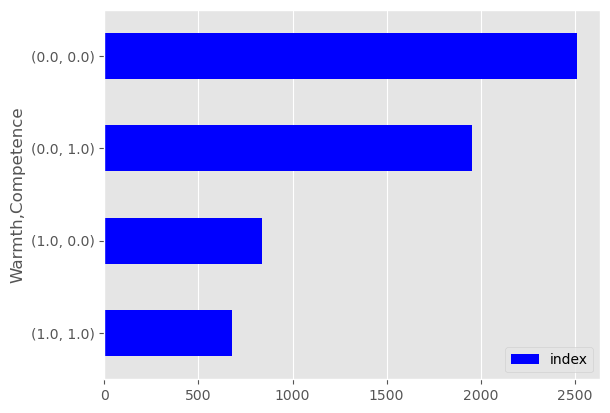

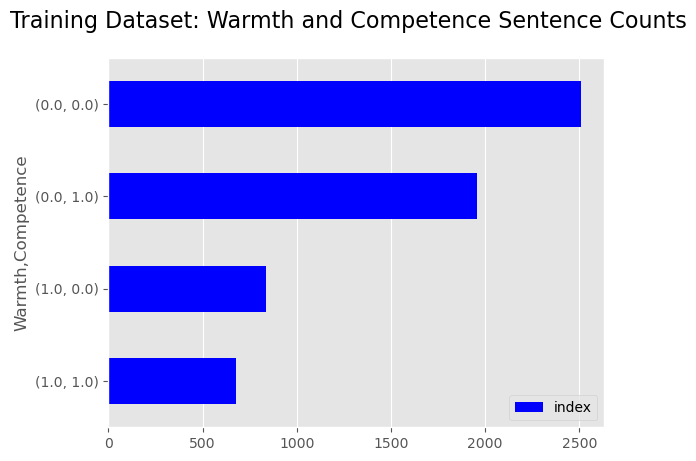

In [18]:
# Visualize data balance
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)

analysis_columns = [
    'Warmth',
    'Competence'
]

df_manual.info()

df_gender_age_info(df_manual, ivs_all = analysis_columns)

warm_comp_count = (
    df_manual[analysis_columns]
    .reset_index()
    .groupby(analysis_columns)
    .count()
    .sort_values(by='index')
)
fig, ax = plt.subplots()
fig.suptitle('Training Dataset: Warmth and Competence Sentence Counts', fontsize=16.0)
warm_comp_count.plot(kind='barh', stacked=True, legend=True, color='blue', ax=ax).grid(
    axis='y'
)
fig.show()

for save_format in ['eps', 'png']:
    fig.savefig(f'{data_dir}/plots/Manual Warmth and Competence Sentence Counts.{save_format}', format=save_format, dpi=3000, bbox_inches='tight')
